# Full Molecule Representations
Here, we study the full representations for a molecule as learned by different MPNNs

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.manifold import Isomap
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from jcesr_ml.benchmark import load_benchmark_data
from jcesr_ml.mpnn import run_model, GraphModel, set_custom_objects
from scipy.stats import sem
from nfp.layers import ReduceAtomToMol
from keras.models import load_model
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import os

Using TensorFlow backend.
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

Load in the water single task model and the dielectric constant model

In [2]:
set_custom_objects()

In [3]:
train_data, test_data = load_benchmark_data()
models = {}
for m in ['single-task', 'dielectric-constant-softplus_no-acn']:
    model = load_model(os.path.join('..', 'mpnn', 'networks', m, '117232-entries', 
                                    '128-nodes', '16384-batch_size', '1.00e-04-learning_rate', 'best_model.h5'))
    with open(os.path.join('..', 'mpnn', 'networks', m, 'converter.pkl'), 'rb') as fp:
        conv = pkl.load(fp)
    models[m] = {
        'conv': conv,
        'model': model
    }

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Extract the Molecular Representation Layer from Each Model
We want the outputs of the "reduce atoms tom molecule" layer. This will have a reasonable representaiton for the molecule

In [4]:
m = models['single-task']['model']

In [5]:
layer = [x for x in m.layers if isinstance(x, ReduceAtomToMol)][0]

In [6]:
for k in models:
    m = models[k]['model']
    rep_layer = [x for x in m.layers if isinstance(x, ReduceAtomToMol)][0]
    models[k]['model'] = GraphModel(inputs=m.inputs, outputs=rep_layer.output)

## Compute the Representations for All Molecules
Do it with both models once so that we can deal with it easily later

In [7]:
for data in tqdm([train_data, test_data]):
    for k, v in models.items():
        data[f'{k}_rep'] = run_model(v['model'], v['conv'], data['smiles_0'], n_jobs=4).tolist()

100%|██████████| 2/2 [03:14<00:00, 97.10s/it] 


## Reduce the Dimensionality to 2D and Plot
To visualize, we are going to drop the space down to 2 dimensions.

In [8]:
downsample_size = 2048
downsample_data = train_data.sample(downsample_size) if len(train_data) > downsample_size else train_data

In [9]:
for k in tqdm(models):
    isomap = Pipeline([('scale', MinMaxScaler()),
                       ('pca', PCA(n_components=128)),
                       ('isomap', Isomap(n_components=2, n_jobs=-1))])\
        .fit(downsample_data[f'{k}_rep'].tolist())
    train_data[f'{k}_2d'] = isomap.transform(train_data[f'{k}_rep'].tolist()).tolist()

100%|██████████| 2/2 [01:17<00:00, 38.78s/it]


Visually compare the quality of the representation for model for water and acetone as a solvent

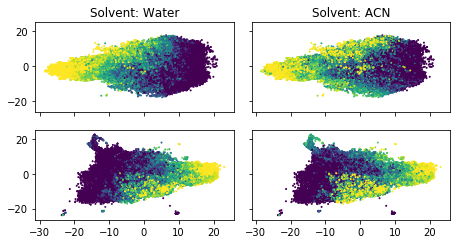

In [10]:
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(6.5, 3.5))

for i, m in enumerate(models):
    subset = train_data.query('n_heavy_atoms==9')
    X = np.array(subset[f'{m}_2d'].tolist())
    for j, s in enumerate(['Water', 'ACN']):
        vmin = np.percentile(data[f'sol_{s.lower()}'], 25)
        vmax = np.percentile(data[f'sol_{s.lower()}'], 95)
        axs[i, j].scatter(X[:, 0], X[:, 1], c=subset[f'sol_{s.lower()}'], s=1, vmin=vmin, vmax=vmax)
        axs[0, j].set_title(f'Solvent: {s}')
            
fig.tight_layout()
fig.savefig(os.path.join('figures', 'mol-rep-comparision.png'), dpi=320)

## Reduce the Dimensionality to Something Smaller and Train a Random Forest Model
Assess whether the water molecule representation used to train an ACN model is better or worse than the multi-task representation. 
We are going to use PCA for speed

In [11]:
n = 128
for k in tqdm(models):
    pca = Pipeline([('scale', MinMaxScaler()), ('pca', PCA(n_components=n))])
    pca.fit(train_data[f'{k}_rep'].tolist())
    for data in [train_data, test_data]:
        data[f'{k}_{n}d'] = pca.transform(data[f'{k}_rep'].tolist()).tolist()

100%|██████████| 2/2 [01:33<00:00, 46.87s/it]


Evaluate the representation from each model.
We are going to use Random Forest because it is fast to train and hard to mess up

In [12]:
model = RandomForestRegressor(n_estimators=256, n_jobs=-1)

In [13]:
subset = train_data.sample(10000)
for k in tqdm(models):
    X_col = f'{k}_{n}d'
    model.fit(subset[X_col].tolist(), subset['sol_acn'])
    test_data[f'{k}_pred'] = model.predict(test_data[X_col].tolist())

100%|██████████| 2/2 [00:17<00:00,  8.50s/it]


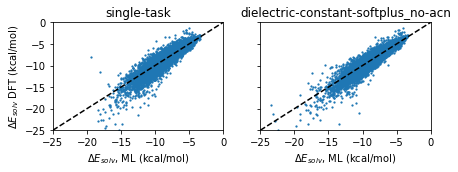

In [14]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6.5, 2.5))

for k, ax in zip(models, axs):
    mae = metrics.mean_absolute_error(test_data[f'{k}_pred'], test_data['sol_acn'])
    ax.scatter(test_data[f'{k}_pred'], test_data['sol_acn'], s=1.5)
    ax.set_title(k)

ax.set_xlim(-25, 0)
ax.set_ylim(ax.get_xlim())

for ax in axs:
    ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')
    ax.set_xlabel('$\Delta E_{solv}$, ML (kcal/mol)')
    
axs[0].set_ylabel('$\Delta E_{solv}$ DFT (kcal/mol)')
fig.tight_layout()

*Finding*: The multi-model seems better qualitatively

## Run the CV Test Many Times
See if the differences are statistically significant. We are going to use a dataset of 10000 and iterate over 4 tests.

In [15]:
sol_cols = [x for x in data.columns if x.startswith('sol_')]

In [16]:
results = []
for sol in tqdm(sol_cols):
    for k in models:
        X_col = f'{k}_{n}d'
        cv_scores = []
        for i in range(4):  # Evaluate over 4 different subsets
            subset = train_data.sample(10000, random_state=i)  # Same subset for each test
            model.fit(subset[X_col].tolist(), subset[sol])
            y_pred = model.predict(test_data[X_col].tolist())
            cv_scores.append(metrics.median_absolute_error(test_data[sol], y_pred))
        results.append({
            'model': k,
            'solvent': sol,
            'cv_scores': cv_scores
        })

100%|██████████| 5/5 [05:34<00:00, 66.84s/it]


In [17]:
results = pd.DataFrame(results)

In [18]:
results['mean'] = results['cv_scores'].apply(np.mean)
results['sem'] = results['cv_scores'].apply(sem)

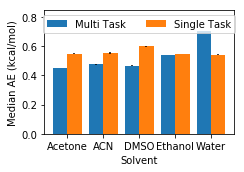

In [19]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for i, (model, group) in enumerate(results.groupby('model')):
    model_name = 'Single Task' if model.startswith('single') else 'Multi Task'
    group = group.sort_values('solvent')
    x = np.arange(len(group)) * 2.5 + i
    ax.bar(x, group['mean'], yerr=group['sem'], width=1, label=model_name)

ax.legend(ncol=2, loc='upper center')
ax.set_xticks(x - 0.5)
ax.set_ylim(0, 0.85)
sol_names = [x.split("_")[-1] for x in group['solvent']]
sol_names = [x.capitalize() if len(x) > 4 else x.upper() for x in sol_names]
ax.set_xticklabels(sol_names)

ax.set_xlabel('Solvent')
ax.set_ylabel('Median AE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'rep-comparison.png'), dpi=320)
fig.savefig(os.path.join('figures', 'rep-comparison.eps'), dpi=320)